In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import scipy.linalg

from tqdm import tqdm

import time as clock
import datetime

In [2]:
def compute_pairwise_norm(x,y):
    
    diff = (x[:, None, :] - y[None, :, :])
    
    norm  = np.linalg.norm(diff, axis = -1)
    
    return norm

def gaussian_kernel(matrix_1, matrix_2, l):
    
    diff = compute_pairwise_norm(matrix_1,matrix_2)
    
    return np.exp(-diff**2/(2*l**2))

def matern_kernel(matrix_1, matrix_2, l):
    
    d = compute_pairwise_norm(matrix_1,matrix_2)
    return (1 + jnp.sqrt(5)*d/l + 5/3*d**2/l**2)*jnp.exp(-jnp.sqrt(5)*d/l)

# Kernel interpolation
We wish to compute 

$$ \int X_sdX_s = \sum_i \sum_j c_i c_j \int_0^T K(t, t_i)dK(t, t_j) = c^\intercal M c$$

where 
$$ M_{i,j} = \int_0^T K(t, t_i)dK(t, t_j)$$

For simplicity

$$ K(t,t_i) = \exp\Big(-\frac{(t-t_i)^2}{2l^2}\Big)$$
and therefore 
$$ dK(t, t_i) = -\frac{(t-t_i)}{l^2}\exp\Big(-\frac{(t-t_i)^2}{2l^2}\Big)$$

In [3]:
from scipy.integrate import quad

from scipy.spatial.distance import pdist

In [4]:
# Generate brownian motion
def generate_bm(delta_t, T, n_samples, seed = 0):
    N = int(T/delta_t)
    bm = []
    x = 0
    time = np.linspace(0, T, N)
    np.random.seed(seed)
    rv = np.random.normal(size = (n_samples, N))

    rv.shape

    bm = np.cumsum(rv*np.sqrt(delta_t), axis = -1)
    
    return bm


delta_t = 0.01
T = 1.0
n_samples = 1000
N = int(T/delta_t)
time = np.linspace(0, T, N)
bm = generate_bm(delta_t, T, n_samples)

In [5]:
bm.shape

(1000, 100)

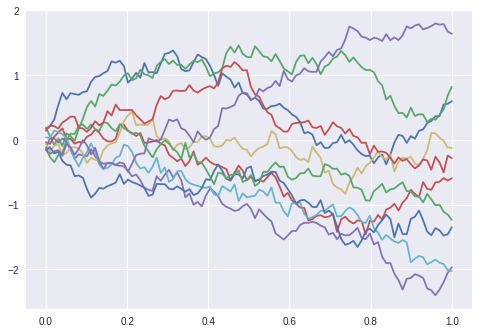

In [6]:
plt.figure()
for i in range(10):
    plt.plot(time, bm[i])

In [7]:
# Compute the M matrix
def compute_M_matrix(N, l):
    M = np.zeros(shape = (N, N))

    for i in range(N):
        for j in range(N):
            t_i = time[i]
            t_j = time[j]
            integrand = lambda t: -(t-t_j)/(l**2)*np.exp(-((t-t_i)**2 + (t-t_j)**2)/(2*l**2))
            M[i,j] = quad(integrand, 0, T)[0]
            
    return M

def compute_interpolant(l, time, Y):
    K = gaussian_kernel(time[:, None], time[:, None], l)
    I = np.eye(K.shape[0])
    nugget = 1e-6
    #print(K.shape)
    c = scipy.linalg.solve(K + nugget*I, Y.T, assume_a='pos')
    
    return K, c.T

In [8]:
l = 0.1
M = compute_M_matrix(N, l)
K, c = compute_interpolant(l, time, bm)
bm_interp = np.squeeze(K@c[:, :, None], axis = -1)

In [9]:
# Compute the interpolation error
np.mean(np.linalg.norm(bm_interp - bm, axis = -1)/np.linalg.norm(bm, axis = -1))

0.13544584237679738

In [10]:
integral = np.sum(c*np.squeeze(M@c[:, :, None], axis = -1), axis = -1)

print(np.mean(np.linalg.norm(integral - bm[:, -1]**2/2)/np.linalg.norm(bm[:, -1]**2/2)))

0.030694081526178783


In [11]:
delta_list = np.linspace(0.005, 0.1, 10)[::-1]

interpolation_error = []
integral_error = []
integral_error_ito = []

kernel_integral = []

l = 0.001
for i in tqdm(range(len(delta_list))):
    delta_t = delta_list[i]
    T = 1.0
    n_samples = 1000
    N = int(T/delta_t)
    
    # Generate the BM
    bm = generate_bm(delta_t, T, n_samples)
    time = np.linspace(0, T, N)
    
    # Compute the M matrix
    M = compute_M_matrix(N,l )
    
    # Compute the interpolant
    #print(time.shape)
    K, c = compute_interpolant(l, time, bm)
    bm_interp = np.squeeze(K@c[:, :, None], axis = -1)

    
    # Compute the interpolation error
    i_error = np.mean(np.linalg.norm(bm_interp - bm, axis = -1)**2/np.linalg.norm(bm, axis = -1)**2)
    interpolation_error.append(i_error)
    
    # Compute the integral
    integral = np.sum(c*np.squeeze(M@c[:, :, None], axis = -1), axis = -1)
    
    kernel_integral.append(integral)
    
    # Compute the integral error 
    int_error = np.mean(np.linalg.norm(integral - bm[:, -1]**2/2)/np.linalg.norm(bm[:, -1]**2/2))
    integral_error.append(int_error)
    
    # Compute the integral error with ito
    int_ito = np.mean(np.linalg.norm(integral - bm[:, -1]**2/2 - 0.5*T)/np.linalg.norm(bm[:, -1]**2/2 - 0.5*T))
    integral_error_ito.append(int_ito)
    
kernel_integral = np.array(kernel_integral)

100%|██████████| 10/10 [00:02<00:00,  4.48it/s]


In [12]:
time.shape

(200,)

In [13]:
np.min(integral_error)

0.008530327533825483

In [14]:
delta_list

array([0.1       , 0.08944444, 0.07888889, 0.06833333, 0.05777778,
       0.04722222, 0.03666667, 0.02611111, 0.01555556, 0.005     ])

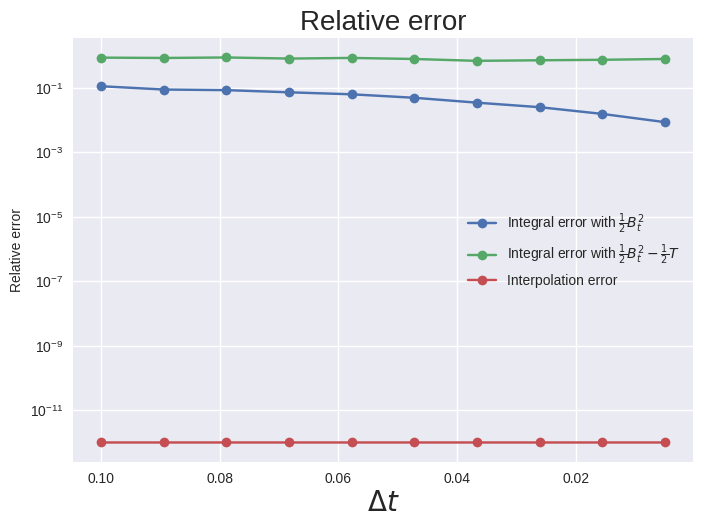

In [15]:
plt.figure()
plt.plot(delta_list, integral_error, marker='o', label = r'Integral error with $\frac{1}{2}B_t^2$')
plt.plot(delta_list, integral_error_ito, marker='o', label = r'Integral error with $\frac{1}{2}B_t^2 - \frac{1}{2}T$')
plt.plot(delta_list,interpolation_error, marker='o',label='Interpolation error')
plt.yscale('log')
plt.xlabel(r'$\Delta t$', size = 20)
plt.ylabel("Relative error", size= 10)
plt.title(r"Relative error", size = 20)
plt.gca().invert_xaxis()
plt.legend()
plt.show()

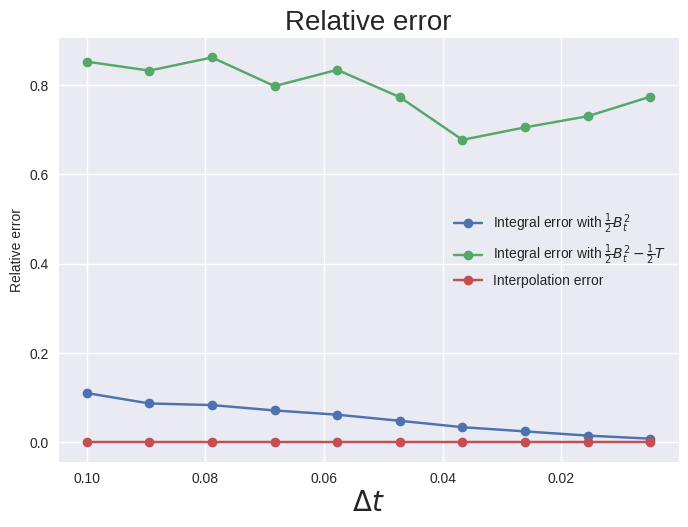

In [16]:
plt.figure()
plt.plot(delta_list, integral_error, marker='o', label = r'Integral error with $\frac{1}{2}B_t^2$')
plt.plot(delta_list, integral_error_ito, marker='o', label = r'Integral error with $\frac{1}{2}B_t^2 - \frac{1}{2}T$')
plt.plot(delta_list,interpolation_error, marker='o',label='Interpolation error')
plt.gca().invert_xaxis()
plt.xlabel(r'$\Delta t$', size = 20)
plt.ylabel("Relative error", size= 10)
plt.title(r"Relative error", size = 20)
plt.legend()
plt.show()

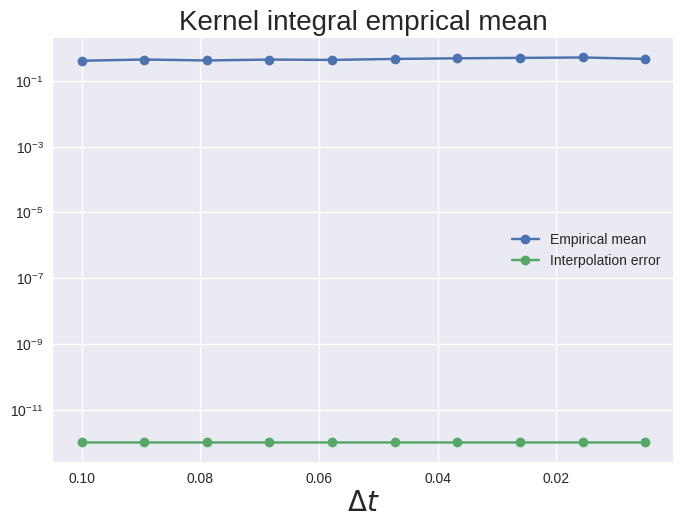

In [17]:
plt.figure()
plt.plot(delta_list, np.mean(kernel_integral, axis  = -1), marker='o',  label = 'Empirical mean')
plt.title("Kernel integral emprical mean", size = 20)
plt.plot(delta_list,interpolation_error, marker='o',label='Interpolation error')
plt.xlabel(r'$\Delta t$', size = 20)
plt.gca().invert_xaxis()
plt.yscale('log')
plt.legend()
plt.show()

# Using the Matern Kernel

In [12]:
from scipy.integrate import quad

from scipy.spatial.distance import pdist

import sympy as sp

In [13]:
delta_t = 0.01
T = 1.0
n_samples = 1000
N = int(T/delta_t)
time = np.linspace(0, T, N)
bm = generate_bm(delta_t, T, n_samples)

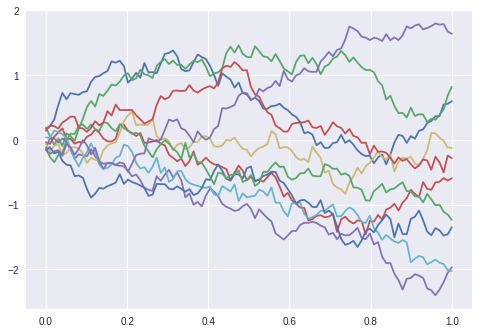

In [14]:
plt.figure()
for i in range(10):
    plt.plot(time, bm[i])

In [15]:
def matern_kernel_32(matrix_1, matrix_2, l):
    
    d = compute_pairwise_norm(matrix_1,matrix_2)
    return (1 + np.sqrt(3)*d/l)*np.exp(-np.sqrt(3)*d/l)

In [16]:
t, s= sp.symbols('t s')
lenghtscale = sp.symbols('l')

t, s, lenghtscale

(t, s, l)

In [17]:
def matern_sp(t,s, l):
    d = sp.sqrt((t-s)**2)
    
    return (1 + sp.sqrt(3)*d/lenghtscale)*sp.exp(-sp.sqrt(3)*d/lenghtscale)

expr = matern_sp(t,s, l)
expr

(1 + sqrt(3)*sqrt((-s + t)**2)/l)*exp(-sqrt(3)*sqrt((-s + t)**2)/l)

The Matern kernel is
$$ 
k(t_i, t_j) = \Big(1 + \frac{\sqrt{3}\sqrt{(t_i -t_j) ^2}}{l}\Big)\exp\Big(- \frac{\sqrt{3}\sqrt{(t_i -t_j) ^2}}{l} \Big)
$$

Therefore $dk(t,s)$

In [18]:
matern_ds = sp.diff(expr, s)
matern_ds

-sqrt(3)*(1 + sqrt(3)*sqrt((-s + t)**2)/l)*(s - t)*sqrt((-s + t)**2)*exp(-sqrt(3)*sqrt((-s + t)**2)/l)/(l*(-s + t)**2) + sqrt(3)*(s - t)*sqrt((-s + t)**2)*exp(-sqrt(3)*sqrt((-s + t)**2)/l)/(l*(-s + t)**2)

In [19]:
def matern_evaluate(t,s,l):
    d = np.sqrt((t-s)**2)
    
    return (1 + np.sqrt(3)*d/l)*np.exp(-np.sqrt(3)*d/l)

def matern_ds_evaluate(x,y,z):
    
    if x == y:
        return 0
    return matern_ds.evalf(subs = {t: x, s:y, lenghtscale: z})

In [20]:
def matern_ds_manual(t,s,l):
    
    d = t-s
    
    a = (1 + np.sqrt(3)*np.abs(d)/l)*np.exp(-np.sqrt(3)*np.abs(d)/l)*(-np.sqrt(3)*d/(np.abs(d)*l))
    b = np.sqrt(3)*d/(np.abs(d)*l)*np.exp(-np.sqrt(3)*np.abs(d)/l)
    return  - (a + b)



In [21]:


a,b,sigma = [1.0, 10.0, 3.0]
matern_evaluate(a,b,sigma), matern_ds_evaluate(a, b, sigma)

(0.03431324319746018, -0.0166134921431474)

In [22]:
matern_ds_manual(a,b,sigma)

-0.01661349214314743

In [23]:
i = 0 
j = 1
t_i = time[i]
t_j = time[j]
l = 1.0
integrand = lambda t: matern_evaluate(t_i,t,l)*matern_ds_manual(t_j,t,l)

In [24]:
integrand(0.1)

-0.22772156675411404

In [25]:
# Compute the M matrix
def compute_M_matrix(N, l):
    M = np.zeros(shape = (N, N))

    for i in range(N):
        for j in range(N):
            t_i = time[i]
            t_j = time[j]
            integrand = lambda t: matern_evaluate(t_i,t,l)*matern_ds_evaluate(t_j,t,l)
            M[i,j] = quad(integrand, 0, T, points=[t_j])[0]
            
    return M

def compute_interpolant(l, time, Y):
    K = matern_kernel_32(time[:, None], time[:, None], l)
    I = np.eye(K.shape[0])
    nugget = 1e-6
    c = scipy.linalg.solve(K + nugget*I, bm.T, assume_a='pos')
    
    return K, c.T

In [26]:
start = clock.time()
l = 0.1
K, c = compute_interpolant(l, time, bm)
bm_interp = np.squeeze(K@c[:, :, None], axis = -1)

end = clock.time()

print(str(datetime.timedelta(seconds = end- start)))

0:00:00.004141


In [27]:
start = clock.time()
M = compute_M_matrix(N, l)
end = clock.time()

print(str(datetime.timedelta(seconds = end- start)))

KeyboardInterrupt: 

In [ ]:
# Compute the interpolation error
np.mean(np.linalg.norm(bm_interp - bm, axis = -1)/np.linalg.norm(bm, axis = -1))

In [ ]:
integral = np.sum(c*np.squeeze(M@c[:, :, None], axis = -1), axis = -1)

print(np.mean(np.linalg.norm(integral - bm[:, -1]**2/2)/np.linalg.norm(bm[:, -1]**2/2)))

In [ ]:
delta_list = np.linspace(0.005, 0.1, 10)[::-1]

interpolation_error = []
integral_error = []
integral_error_ito = []

kernel_integral = []

l = 0.001
for i in tqdm(range(len(delta_list))):
    delta_t = delta_list[i]
    T = 1.0
    n_samples = 1000
    N = int(T/delta_t)
    
    # Generate the BM
    bm = generate_bm(delta_t, T, n_samples)
    time = np.linspace(0, T, N)
    
    # Compute the M matrix
    M = compute_M_matrix(N,l )
    
    # Compute the interpolant
    K, c = compute_interpolant(l, time, bm)
    bm_interp = np.squeeze(K@c[:, :, None], axis = -1)

    
    # Compute the interpolation error
    i_error = np.mean(np.linalg.norm(bm_interp - bm, axis = -1)/np.linalg.norm(bm, axis = -1))
    interpolation_error.append(i_error)
    
    # Compute the integral
    integral = np.sum(c*np.squeeze(M@c[:, :, None], axis = -1), axis = -1)
    
    kernel_integral.append(integral)
    
    # Compute the integral error 
    int_error = np.mean(np.linalg.norm(integral - bm[:, -1]**2/2)/np.linalg.norm(bm[:, -1]**2/2))
    integral_error.append(int_error)
    
    # Compute the integral error with ito
    int_ito = np.mean(np.linalg.norm(integral - bm[:, -1]**2/2 - 0.5*T)/np.linalg.norm(bm[:, -1]**2/2 - 0.5*T))
    integral_error_ito.append(int_ito)
    
kernel_integral = np.array(kernel_integral)

In [ ]:
np.min(integral_error)

In [ ]:
delta_list

In [ ]:
plt.figure()
plt.plot(delta_list, integral_error, marker='o', label = r'Integral error with $\frac{1}{2}B_t^2$')
plt.plot(delta_list, integral_error_ito, marker='o', label = r'Integral error with $\frac{1}{2}B_t^2 - \frac{1}{2}T$')
plt.plot(delta_list,interpolation_error, marker='o',label='Interpolation error')
plt.yscale('log')
plt.xlabel(r'$\Delta t$', size = 20)
plt.ylabel("Relative error", size= 10)
plt.title(r"Relative error", size = 20)
plt.gca().invert_xaxis()
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(delta_list, integral_error, marker='o', label = r'Integral error with $\frac{1}{2}B_t^2$')
plt.plot(delta_list, integral_error_ito, marker='o', label = r'Integral error with $\frac{1}{2}B_t^2 - \frac{1}{2}T$')
plt.plot(delta_list,interpolation_error, marker='o',label='Interpolation error')
plt.gca().invert_xaxis()
plt.xlabel(r'$\Delta t$', size = 20)
plt.ylabel("Relative error", size= 10)
plt.title(r"Relative error", size = 20)
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(delta_list, np.mean(kernel_integral, axis  = -1), marker='o')
plt.title("Kernel integral emprical mean", size = 20)
plt.plot(delta_list,interpolation_error, marker='o',label='Interpolation error')
plt.xlabel(r'$\Delta t$', size = 20)
plt.gca().invert_xaxis()
plt.yscale('log')
plt.show()